In [40]:
import numpy as np
import networkx as nx
import math
import itertools

### Pagerank eigenvalue and iterative

$
L_1 =
    \begin{bmatrix}
        0 \\
        1 \\
        1 \\
    \end{bmatrix},
L_2 = 
    \begin{bmatrix}
        0 \\
        0 \\
        1 \\
    \end{bmatrix},
L_3 = 
    \begin{bmatrix}
        1 \\
        0 \\
        0 \\
    \end{bmatrix},
L =  
    \begin{bmatrix}
        0 & 0 & 1 \\
        1 & 0 & 0 \\
        1 & 1 & 0 \\
    \end{bmatrix},
R =  
    \begin{bmatrix}
        0 & 0 & 1 \\
        0.5 & 0 & 0 \\
        0.5 & 1 & 0 \\
    \end{bmatrix},
\vec{p} =
    \begin{bmatrix}
        0.667 \\
        0.333 \\
        0.667 \\
  \end{bmatrix}
$

In [24]:
def create_Rmatrix(L):
    """
    This matrix will take a L (NxN) matrix in and create a R matrix
    """
    #R = np.multiply(L, 1 / np.sum(L,axis=0)) # - faster runtime if no column is zero

    X = np.sum(L,axis=0)
    n_nodes = L.shape[0]
    R = np.zeros((n_nodes, n_nodes))
    for i in range(L.shape[0]):
        for j in range(L.shape[1]):
            R[i,j] = L[i,j] / X[0,j] if X[0,j] != 0 else 0
            
    #R = np.multiply(L,R)
    return R

In [25]:
def pagerank_eigen(L, R=None):
    #Construct transition probability matrix from L
    if R is None: R = create_Rmatrix(L)
    #Compute eigen-vectors and eigen-values of R
    eigenvalues, eigenvectors = np.linalg.eig(R)
    #Take the eigen-vector with maximum eigven-value
    p = eigenvectors[:,np.argmax(np.absolute(eigenvalues))]
    return (R,p)

In [ ]:
def pagerank_iterative(L, R=None):
    if R is None: #We might want to compute R outside this function to avoid recomputing large matrix
        R = np.multiply(L, 1 / np.sum(L,axis=0))
    
    N = R.shape[0]
    e = np.ones(shape=(N,1))
    q = 0.9

    p = e
    delta = 1
    epsilon = 0.001
    i = 0
    while delta > epsilon:
        p_prev = p
        p = np.matmul(q * R, p_prev)
        p = p + (1-q) / N * e
        delta = np.linalg.norm(p-p_prev,1)
        i += 1

    print("Converged after {0} iterations".format(i))
    return R,p

In [26]:
L = np.matrix([
    [0,0,1], 
    [1,0,0], 
    [1,1,0]
])

create_Rmatrix(L)
pagerank_eigen(L);

### HITS Algorithm - hubs and authorities

In [ ]:
def hits_iterative(A, k = 10):
    N = A.shape[0]
    auth0, hub0 = 1 / (N*N) * np.ones(N), 1 / (N*N) * np.ones(N) 
    authprev, hubprev = auth0, hub0
    delta1 = delta2 = 1
    epsilon = 0.001 # We can strictly check for convergence rate of HITS algorithm
    l = 0
    while l < k and delta1 > epsilon and delta2 > epsilon:
        hub = np.matmul(A, authprev)
        auth = np.matmul(np.transpose(A), hub) 
        auth = auth / np.linalg.norm(auth,2)
        hub = hub / np.linalg.norm(hub,2)
        delta1 = np.linalg.norm(auth-authprev,1)
        delta2 = np.linalg.norm(hub-hubprev,1)
        authprev = auth
        hubprev = hub
        l += 1
    
    print("Ran a total of {0} iterations with the convergence rate delta1, delta2={1},{2}".format(l, delta1, delta2))
    return authprev, hubprev

### Modularity

In [27]:
import itertools
# The community label of a node can be accessed by G[node_id]['community']
# The degree of a node: G.degree[node_id]
# The neighbors of a node: G.neighbors(node_id)
# Number of edges between 2 nodes: G.number_of_edges(node_1, node_2)
def compute_modularity(G):
    m = len(G.edges)
    Q = 0
    nodes_dct = {}
    
    # Makes a nodes_dct: key: community | value: [list of nodes in community]
    for node in G.nodes:
        community = G.nodes[node]['community']
        if community in nodes_dct:
            current_list = nodes_dct[community]
            current_list.append(node)
            nodes_dct[community] = current_list
        else:
            nodes_dct[community] = [node]
            
    
    # number of links between nodes in module "S"    
    for community, value_list in nodes_dct.items():
        ls = 0
        ds = 0
        combinations = itertools.combinations(value_list, 2)
        # finds number of links between nodes in each module
        for subset in combinations: 
            links = G.number_of_edges(subset[0],subset[1])
            ls += links
        for node_id in value_list:
            ds += G.degree[node_id]
        Q += ls/m - (ds/(2*m))**2
                  
    return Q

### Betweenness centrality
Normalized: True/False

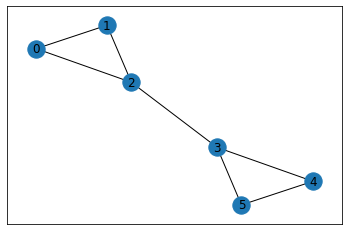

In [30]:
M = ["0,1,2",
"1,0,2",
"2,0,1,3",
"3,2,4,5",
"4,3,5",
"5,3,4"
    ]
G=nx.parse_adjlist(M, nodetype=int, delimiter=",")
nx.draw_networkx(G)

In [35]:
nx.betweenness_centrality(G, k=None, normalized=True, weight=None,seed=None)
nx.edge_betweenness_centrality(G, k=None, normalized=False, weight=None,seed=None)

{(0, 1): 1.0,
 (0, 2): 4.0,
 (1, 2): 4.0,
 (2, 3): 9.0,
 (3, 4): 4.0,
 (3, 5): 4.0,
 (4, 5): 1.0}

## Collaberative predictions

**Cosine similarity for items and users. Only difference is the transpose:**

In [63]:
# from sklearn.metrics.pairwise import pairwise_distances
# user_similarity = 1- pairwise_distances(train_data_matrix, metric='cosine')
# item_similarity = 1-pairwise_distances(train_data_matrix.T, metric='cosine')


In [77]:
from sklearn.metrics.pairwise import cosine_similarity
arr_1 = np.array([1,2,3])
arr_2 = np.array([[1,2,3], [2,3,4], [10,21,43]])
cos_sim = cosine_similarity(arr_1.reshape(1,-1), arr_2)
result = np.argsort(cos_sim, axis=-1, order=None).flatten()
np.flip(result)

array([0, 1, 2])

### User based prediction

In [36]:
def user_based_predict(ratings, similarity):
    pred = np.zeros(ratings.shape)
    numb_users, numb_items = ratings.shape
    avg_vec = np.true_divide(ratings.sum(1),(ratings!=0).sum(1))
    
    for a in tqdm(range(numb_items)):
        for x in range(numb_users):
            if ratings[x, a] == 0:
                
                avg_x = avg_vec[x]
                avg_vec_rest = np.append(avg_vec[:x], avg_vec[x+1:])
                item_a_ratings = np.append(ratings[:,a][:x], ratings[:,a][x+1:])
                sim_vec = np.delete(similarity[x],x)
                
                mask = (item_a_ratings != 0)
                # Only do the subtraction where both A1 & A2 are nonzero,
                # otherwise copy the A2 value
                over = np.where(mask, sim_vec*(item_a_ratings-avg_vec_rest), 0).sum()
                under = np.absolute(np.where(mask, sim_vec, 0)).sum()
                
                if under > 0:
                    pred[x, a] = avg_x + over/under
                else: 
                    pred[x, a] = avg_x 
            
            else:
                pred[x, a] = ratings[x, a]
  
            if under > 0:
                pred[x, a] = avg_x + over/under
            else:
                pred[x, a] = avg_x

    return pred


## solution based
def user_based_predict(ratings, similarity):
    filled_matrix = np.zeros((n_users, n_items))
    
    # compute the average ratings for each user
    tmp = train_data_matrix.copy()
    tmp[tmp == 0] = np.nan
    user_average_ratings = np.nanmean(tmp, axis=1)
    
    # loop over all the items
    for i in tqdm(range(n_items)):
        # get the users who rated this item
        ranked_users_indices = train_data_matrix[:,i].nonzero()[0]

        for u in range(n_users):
            numerator = 0
            denominator = 0
            for y in ranked_users_indices:
                numerator+=user_similarity[u,y]*(train_data_matrix[y,i]-user_average_ratings[y])
                denominator+=np.abs(user_similarity[u,y])
            if denominator>0:
                filled_matrix[u,i]= user_average_ratings[u]+ numerator/denominator
            else:
                filled_matrix[u,i]= user_average_ratings[u]

    # we ensure that the ratings are in the expected range
    filled_matrix.clip(0,5)
    return filled_matrix  

### Item based prediction

In [37]:
def item_based_predict(ratings, similarity):
    pred = np.zeros(ratings.shape)
    numb_users, numb_ratings = ratings.shape
    for user_id, user_ratings in tqdm(enumerate(ratings)):
        for movie_i, movie_rating in enumerate(user_ratings):
            # Then the movie is not rated yet
            if movie_rating == 0:
                movie_sum = 0
                movie_count = 0
                for i in range(numb_ratings):
                    cur_rating = user_ratings[i]
                    if cur_rating > 0:
                        movie_sum += cur_rating*similarity[movie_i,i]
                        movie_count += np.abs(similarity[movie_i,i])
                if movie_count > 0:
                    pred_rating = movie_sum/movie_count
                    pred[user_id, movie_i] = pred_rating
                else:
                    pred[user_id, movie_i] = np.random.randint(1,6, dtype=int)
            else:
                pred[user_id, movie_i] = ratings[user_id, movie_i]
                
    return pred

## solution based
def item_based_predict(ratings, similarity):
    filled_matrix = np.zeros((n_users, n_items))
    # loop over all the users
    for u in tqdm(range(n_users)):
        # get the items rated by this user
        ranked_items_indices = train_data_matrix[u,:].nonzero()[0]
        for i in range(n_items):
            numerator = 0
            denominator = 0
            for j in ranked_items_indices:
                numerator+=item_similarity[i,j]*train_data_matrix[u,j]
                denominator+=np.abs(item_similarity[i,j])
            if denominator>0:
                filled_matrix[u,i]= numerator/denominator
            else:
                # simply take a random rating in that case 
                filled_matrix[u,i]= np.random.randint(1,6)
    return filled_matrix  

## TF-IDF

In [38]:
# IDF
def idf_values(vocabulary, documents):
    idf = {}
    num_documents = len(documents)
    for i, term in enumerate(vocabulary):
        counter = 0
        for doc in documents:
            if term in set(doc):
                counter += 1
        idf[term] = math.log(num_documents/counter, math.e)
    return idf

# TF-IDF
# Function to generate the vector for a document (with normalisation)
def vectorize(document, vocabulary, idf):
    vector = [0]*len(vocabulary)
    counts = Counter(document)
    max_count = counts.most_common(1)[0][1]
    for i,term in enumerate(vocabulary):
        vector[i] = idf[term]*counts[term]/max_count # YOUR CODE HERE
    return vector

### Cosine similarity 

In [50]:
import math
v1, v2 = np.array([1,2,3,4,5,6,7,8,9,10]), np.array([1,2,12,4,23,6,23,8,9,1])

In [48]:
def cosine_similarity_math(v1,v2):
    sumxx, sumxy, sumyy = 0, 0, 0
    for i in range(len(v1)):
        x = v1[i]; y = v2[i]
        sumxx += x*x
        sumyy += y*y
        sumxy += x*y
    if sumxy == 0:
            result = 0
    else:
            result = sumxy/(math.sqrt(sumxx*sumyy))  # YOUR CODE HERE
    return result

0.7124637297801573

In [51]:
def cosine_similarity_speed(v1, v2):
    return np.dot(v1,v2)/np.sqrt(np.dot(v1,v1)*np.dot(v2,v2))

### Map score

In [59]:
def compute_map2(queries, K=10):
    map_score = 0
    for i, query in enumerate(queries):
        predict = search_vec(query, K)
        gt = search_vec_sklearn(query, features)
        p_int = []
        for k in range(K, 0, -1):
            pk = compute_precision_at_k(predict, gt, k)
            
            # Compute interpolated precision
            pint_k = max([pk] + p_int)
            
            # Prepend pint_k to p_int
            p_int.insert(0, pint_k)
        # Only consider precision values when retrieving a relevant document
        p_int_relevant = sum(p_int[i] for i, retrieved in enumerate(predict) if retrieved in gt)
        
        # Divide by number of relevant documents
        map_score += p_int_relevant / len(gt)
    map_score = map_score / len(queries)
    return map_score

### Rocchio algorithm
\begin{equation}
\vec{q_m} = \alpha \vec{q_0} + \frac{\beta}{|D_r|} \sum_{\vec{d_j} \in D_r} \vec{d_j} - \frac{\gamma}{|D_{nr}|} \sum_{\vec{d_j} \in D_{nr}} \vec{d_j}
\end{equation}

In [61]:
def rocchio_algo(relevant_doc_vecs, non_relevant_doc_vecs, query_vector, alpha, beta, gamma):
    relevant_doc_vecs = np.array(relevant_doc_vecs)
    non_relevant_doc_vecs = np.array(non_relevant_doc_vecs)
    query_vector = np.array(query_vector)
#    print(relevant_doc_vecs.shape)
#    print(non_relevant_doc_vecs.shape)
#    print(query_vector.shape)
    
    num_rel = len(relevant_doc_vecs)
    num_non_rel = len(non_relevant_doc_vecs)
    
    # Compute the first term in the Rocchio equation
    norm_query_vector = alpha*query_vector
    
    # Compute the second term in the Rocchio equation

    norm_sum_relevant = (beta/num_rel)*relevant_doc_vecs.sum(axis=0)
    
    # Compute the last term in the Rocchio equation

    norm_sum_non_relevant = -(gamma/num_non_rel)*non_relevant_doc_vecs.sum(axis=0)
    
    # Sum all the terms
    modified_query_vector = norm_query_vector + norm_sum_relevant + norm_sum_non_relevant
    
    # Ignore negative elements
    modified_query_vector = np.where(modified_query_vector<0, 0, modified_query_vector)
    return modified_query_vector

### Fagins aglorithm

In [62]:
def fagin_algorithm(query, h, k, vocabulary):
    
    # Split and stem the query
    q = query.split()
    q = set([stemmer.stem(w) for w in q])
    query_term_cnt = len(q)
    
    # select the posting lists for the query terms
    posting_lists = {}
    for term in q:
        if term in h:
            posting_lists[term] = h[term]
    
    max_len = len(documents)
    
    # Traverse the selected posting lists until we found k documents that appear in ALL posting lists
    # This corresponds to phase 1 of Fagin's algorithm.
    # As a result you produce a dictionary documents_occurrences, with the document identifiers as keys, 
    # and the number of documents found as value.
    # We stop traversing the posting lists until we have found k documents that appear in ALL posting lists 
    # of the query terms
    
    documents_occurrences = {}
    k_countdown = k
    for i in range(max_len):
        for key, val in posting_lists.items():
            if val[0] in documents_occurrences:
                documents_occurrences[val[i][0]] += 1
                if documents_occurrences[val[i][0]] == k:
                    k_countdown -= 1
            else:
                documents_occurrences[val[i][0]] = 1
        if k_countdown == 0:
            break
                
            
        

    # YOUR CODE HERE
                

        
    # Retrieve for the found documents the tfidf values and add them up.
    # For simplicity, we do not distinguish the cases whether the values have already been retrieved in the 
    # previous phase, or whether we use random access to obtain those values
    
    tfidf = {}
    for d in documents_occurrences.keys():
        t = 0
        for term in q:
            t = t + dict(posting_lists[term])[d]
        tfidf[d] = t
        
    # Finally we compute the top-k documents and return the answer
    
    ans = sorted(tfidf.items(), key=lambda x:x[1], reverse = True)[:k]
    return ans